# **1. Predicción de demanda**

# Importación de liberías

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [46]:
ds_demand = pd.read_csv(r'Inputs\dataset_demand_acumulate.csv',sep=',')

In [47]:
# Trabajar con los datos
ds_demand_base = ds_demand.copy()
# Convertir la columna 'year_month' a un índice datetime
ds_demand_base['year_month'] = pd.to_datetime(ds_demand_base['year_month'], format='%Y-%m')
ds_demand_base.set_index('year_month', inplace=True)
ds_demand_base

,Demand
year_month,
2017-01-01,1211.009490
2017-02-01,1660.584649
2017-03-01,3182.587014
2017-04-01,3506.515270
2017-05-01,4554.082280
...,...
2021-12-01,3006.311107
2022-01-01,217.314949
2022-02-01,332.062614


# Visualizaciones (para concoer el tema de estacionalidad)

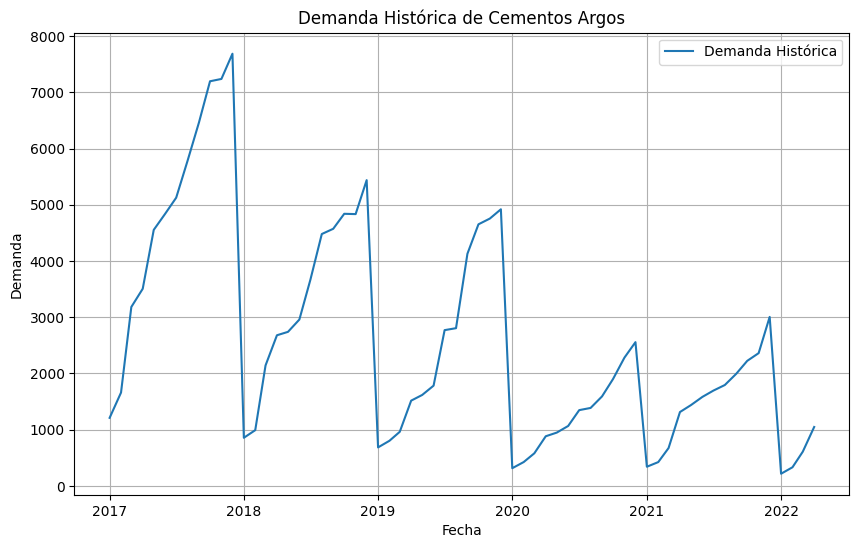

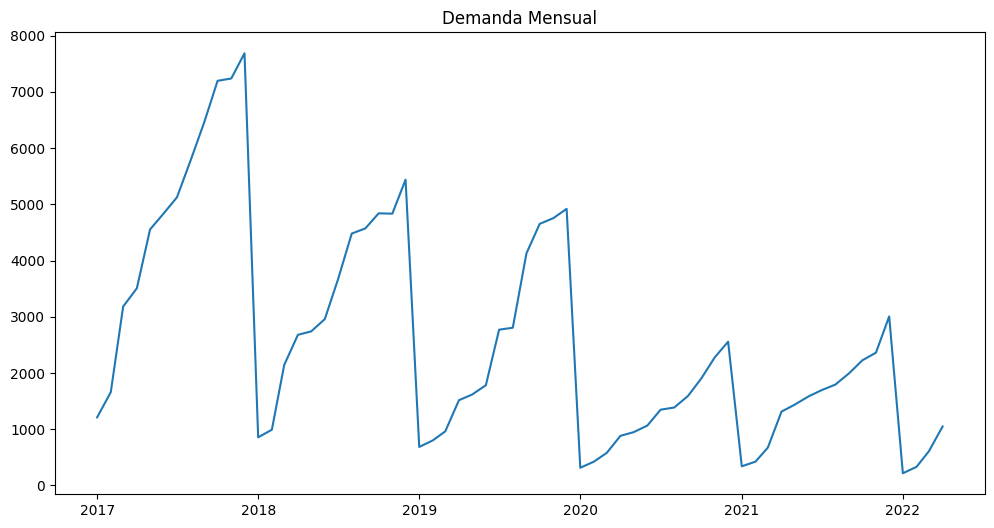

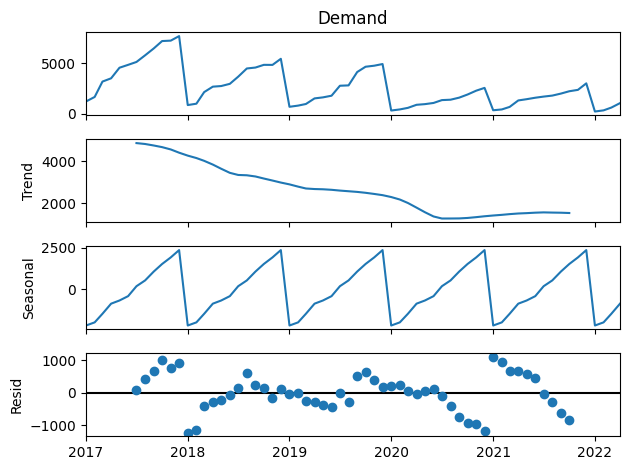

In [48]:
# Demanda histórica
plt.figure(figsize=(10, 6))
plt.plot(ds_demand_base.index, ds_demand_base['Demand'], label='Demanda Histórica')
plt.title('Demanda Histórica de Cementos Argos')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.grid(True)
plt.show()

# Visualizar la serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(ds_demand_base['Demand'])
plt.title('Demanda Mensual')
plt.show()

# Descomposición de la serie (ejemplo)
decomposition = seasonal_decompose(ds_demand_base['Demand'], model='additive')
decomposition.plot()
plt.show()

# Entrenamiento del modelo

Se utiliza SARIMA por el tema de estacionalidades

In [49]:
# Ajustar el modelo SARIMA (ejemplo)
model = SARIMAX(ds_demand_base['Demand'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Hacer predicciones
future_dates = pd.date_range(start='2022-05-01', end='2022-07-01', freq='MS')
future_df = pd.DataFrame(index=future_dates, columns=ds_demand_base.columns)
forecast = results.forecast(steps=3)
future_df['Demand'] = forecast

c:\Users\jisaza53\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\jisaza53\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\jisaza53\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jisaza53\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

# Grafica con predicción

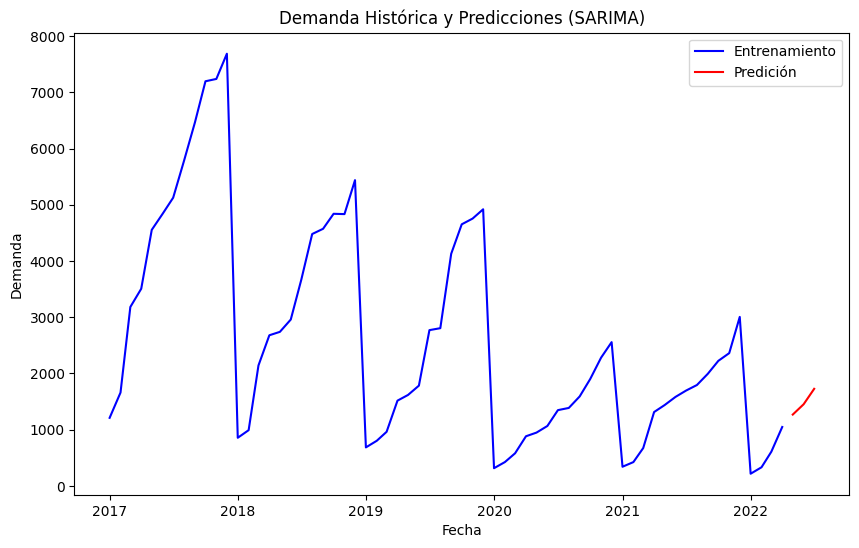

In [50]:
# Graficar los datos históricos (Entrenamiento) y las predicciones (Prueba) en la misma gráfica
plt.figure(figsize=(10, 6))
plt.plot(ds_demand_base.index, ds_demand_base['Demand'], label='Entrenamiento', color='blue')  # Datos históricos
plt.plot(future_df.index, future_df['Demand'], label='Predición', color='red')  # Predicciones

# Añadir etiquetas y leyenda
plt.title('Demanda Histórica y Predicciones (SARIMA)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()

# Evaluación del modelo

In [51]:
# Prueba de estacionariedad (ejemplo)
result = adfuller(ds_demand_base['Demand'])

# Evaluar el modelo
y_true = ds_demand_base['Demand'][-3:]  # Últimos 3 valores reales

# Access the predicted values from the forecast object
predicted_values = forecast.values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, predicted_values))
mae = mean_absolute_error(y_true, predicted_values)
mape = np.mean(np.abs((y_true - predicted_values) / y_true)) * 100

print("RMSE (Root Mean Squared Error - Error Cuadrático Medio Raíz):", rmse)
print("MAE (Mean Absolute Error - Error Absoluto Medio):", mae)
print("MAPE (Mean Absolute Percentage Error - Error Absoluto Porcentual Medio):", mape)

print('ADF Statistic (Estadística de la prueba ADF - Augmented Dickey-Fuller Test): %f' % result[0])
print('p-value (Valor p del test ADF): %f' % result[1])

RMSE (Root Mean Squared Error - Error Cuadrático Medio Raíz): 826.8175995910296
MAE (Mean Absolute Error - Error Absoluto Medio): 819.8773069200448
MAPE (Mean Absolute Percentage Error - Error Absoluto Porcentual Medio): 161.82739434154084
ADF Statistic (Estadística de la prueba ADF - Augmented Dickey-Fuller Test): -4.441016
p-value (Valor p del test ADF): 0.000251


In [52]:
ds_demand_base.reset_index(inplace=True)
future_df.reset_index(inplace=True)
future_df.rename(columns={'index': 'year_month'}, inplace=True)
ds_final = pd.concat([ds_demand_base, future_df], ignore_index=True)
ds_final

,year_month,Demand
0,2017-01-01,1211.009490
1,2017-02-01,1660.584649
2,2017-03-01,3182.587014
3,2017-04-01,3506.515270
4,2017-05-01,4554.082280
...,...,...
62,2022-03-01,609.119726
63,2022-04-01,1048.486287
64,2022-05-01,1269.200235
65,2022-06-01,1453.012693
